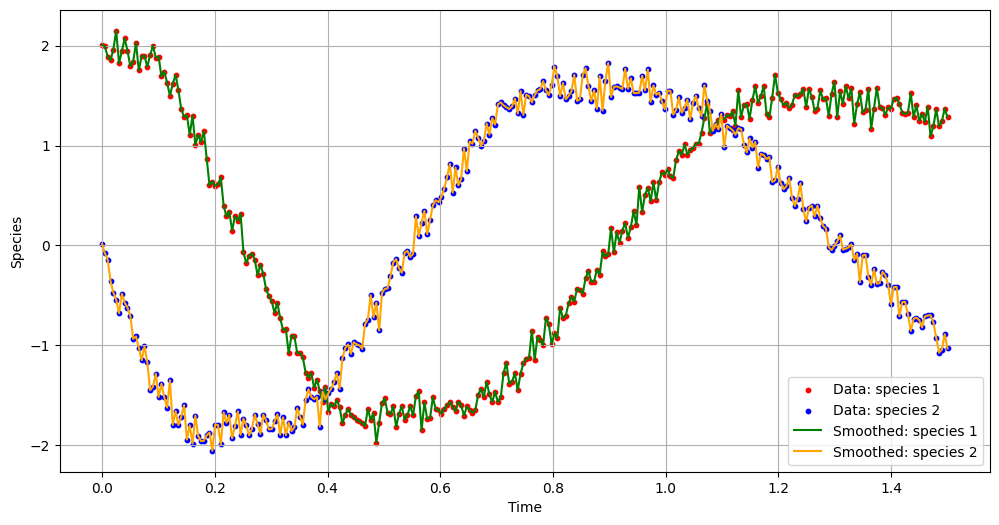

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the true ODE function
def true_ode_func(u, t):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    du = np.dot(true_A, u**3)
    return du

# Initial conditions and time points
u0 = np.array([2.0, 0.0])
tspan = (0.0, 1.5)
datasize = 300
tsteps = np.linspace(tspan[0], tspan[1], datasize)

# Solve the true ODE
data = odeint(true_ode_func, u0, tsteps) + 0.1 * np.random.randn(datasize, 2)

# Perform Gaussian Process Regression for collocation
def collocate_data(data, tsteps):
    du = np.zeros_like(data)
    u_smoothed = np.zeros_like(data)
    for i in range(data.shape[1]):
        # Define the kernel and Gaussian process regressor
        kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        
        # Fit to data
        gp.fit(tsteps.reshape(-1, 1), data[:, i])
        
        # Predict smoothed values and derivatives
        u_smoothed[:, i], sigma = gp.predict(tsteps.reshape(-1, 1), return_std=True)
        du[:, i] = gp.kernel_.k1.constant_value * gp.kernel_.k2.length_scale**2 * np.gradient(u_smoothed[:, i], tsteps)
        
    return du, u_smoothed

# Get collocated data
du, u_smoothed = collocate_data(data, tsteps)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.scatter(tsteps, data[:, 0], label='Data: species 1', color='red', s=10)
plt.scatter(tsteps, data[:, 1], label='Data: species 2', color='blue', s=10)
plt.plot(tsteps, u_smoothed[:, 0], label='Smoothed: species 1', color='green')
plt.plot(tsteps, u_smoothed[:, 1], label='Smoothed: species 2', color='orange')
plt.xlabel('Time')
plt.ylabel('Species')
plt.legend()
plt.grid(True)
plt.show()


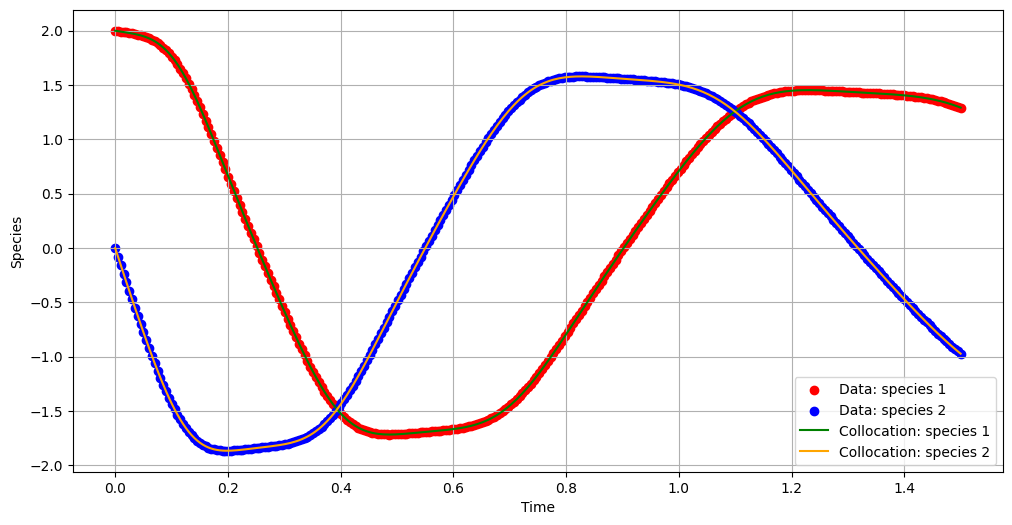

In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# Define the true ODE function
def true_ode_func(u, t):
    true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
    du = np.dot(true_A, u**3)
    return du

# Initial conditions and time points
u0 = np.array([2.0, 0.0])
tspan = (0.0, 1.5)
datasize = 300
tsteps = np.linspace(tspan[0], tspan[1], datasize)

# Solve the true ODE
data = odeint(true_ode_func, u0, tsteps)

# Perform smoothing using UnivariateSpline
def collocate_data(data, tsteps):
    du = np.zeros_like(data)
    for i in range(data.shape[1]):
        spline = UnivariateSpline(tsteps, data[:, i], s=0.5)
        du[:, i] = spline.derivative()(tsteps)
    return du, data

# Get collocated data
du, u = collocate_data(data, tsteps)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.scatter(tsteps, data[:, 0], label='Data: species 1', color='red')
plt.scatter(tsteps, data[:, 1], label='Data: species 2', color='blue')
plt.plot(tsteps, u[:, 0], label='Collocation: species 1', color='green')
plt.plot(tsteps, u[:, 1], label='Collocation: species 2', color='orange')
plt.xlabel('Time')
plt.ylabel('Species')
plt.legend()
plt.grid(True)
plt.show()
